In [1]:
!pip install datasets

# Step 3: If you're using Hugging Face Datasets, register the dataset
from datasets import Dataset

# Load the saved CSV file
train_dataset = Dataset.from_csv('Copy of train_dataset.csv')
train_dataset

validation_dataset = Dataset.from_csv('Copy of validation_dataset.csv')
validation_dataset


  Obtaining dependency information for datasets from https://files.pythonhosted.org/packages/95/fc/661a7f06e8b7d48fcbd3f55423b7ff1ac3ce59526f146fda87a1e1788ee4/datasets-2.18.0-py3-none-any.whl.metadata
  Using cached datasets-2.18.0-py3-none-any.whl.metadata (20 kB)
  Obtaining dependency information for pyarrow>=12.0.0 from https://files.pythonhosted.org/packages/fd/12/e8f27c60e75ddb562b0258db472f3e49253eca2f169fb2665738035566dd/pyarrow-15.0.2-cp38-cp38-manylinux_2_28_x86_64.whl.metadata
  Using cached pyarrow-15.0.2-cp38-cp38-manylinux_2_28_x86_64.whl.metadata (3.0 kB)
  Obtaining dependency information for pyarrow-hotfix from https://files.pythonhosted.org/packages/e4/f4/9ec2222f5f5f8ea04f66f184caafd991a39c8782e31f5b0266f101cb68ca/pyarrow_hotfix-0.6-py3-none-any.whl.metadata
  Using cached pyarrow_hotfix-0.6-py3-none-any.whl.metadata (3.6 kB)
  Obtaining dependency information for xxhash from https://files.pythonhosted.org/packages/ad/80/8fc9a4d76b259c901f2c85ed10f330a8fb51993a577bd

Dataset({
    features: ['reviewText', 'overall'],
    num_rows: 405
})

In [2]:
from datasets import DatasetDict, load_dataset

# Create a DatasetDict with train and validation splits
split_dataset = DatasetDict({'train': train_dataset, 'validation': validation_dataset})
split_dataset


DatasetDict({
    train: Dataset({
        features: ['reviewText', 'overall'],
        num_rows: 2698
    })
    validation: Dataset({
        features: ['reviewText', 'overall'],
        num_rows: 405
    })
})

In [3]:
!pip install transformers[torch]

  Obtaining dependency information for transformers[torch] from https://files.pythonhosted.org/packages/15/fc/7b6dd7e1adc0a6407b845ed4be1999e98b6917d0694e57316d140cc85484/transformers-4.39.3-py3-none-any.whl.metadata
  Using cached transformers-4.39.3-py3-none-any.whl.metadata (134 kB)
  Obtaining dependency information for regex!=2019.12.17 from https://files.pythonhosted.org/packages/eb/10/4ccc8eed80f11c082a2883d49d4090aa80c7f65704216a529f490cb089b1/regex-2023.12.25-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Using cached regex-2023.12.25-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (40 kB)
  Obtaining dependency information for tokenizers<0.19,>=0.14 from https://files.pythonhosted.org/packages/0e/d7/3220a4483d240180d0b9423206cc57a4997fd4b49a8393e5ce9a2f7908a9/tokenizers-0.15.2-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Using cached tokenizers-0.15.2-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadat

In [4]:
!pip install evaluate accelerate

  Obtaining dependency information for evaluate from https://files.pythonhosted.org/packages/70/63/7644a1eb7b0297e585a6adec98ed9e575309bb973c33b394dae66bc35c69/evaluate-0.4.1-py3-none-any.whl.metadata
  Using cached evaluate-0.4.1-py3-none-any.whl.metadata (9.4 kB)
  Obtaining dependency information for responses<0.19 from https://files.pythonhosted.org/packages/79/f3/2b3a6dc5986303b3dd1bbbcf482022acb2583c428cd23f0b6d37b1a1a519/responses-0.18.0-py3-none-any.whl.metadata
  Using cached responses-0.18.0-py3-none-any.whl.metadata (29 kB)
Using cached evaluate-0.4.1-py3-none-any.whl (84 kB)
Using cached responses-0.18.0-py3-none-any.whl (38 kB)


In [5]:
from transformers import GPT2Tokenizer

tokenizer = GPT2Tokenizer.from_pretrained("gpt2", padding=True)
tokenizer.pad_token = tokenizer.eos_token

In [16]:
def tokenize_function(examples):
    return tokenizer(examples["reviewText"], truncation=True)

# Now you can use the .map() method on the train_dataset
tokenized_datasets = split_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/2698 [00:00<?, ? examples/s]

Map:   0%|          | 0/405 [00:00<?, ? examples/s]

In [17]:
# Extract actual labels from the validation split of the tokenized datasets
actual_labels = tokenized_datasets['validation']['overall']
actual_labels

# Extract review texts from validation dataset
review_texts = tokenized_datasets['validation']['reviewText']


In [7]:
tokenized_datasets = tokenized_datasets.remove_columns(["reviewText"])
tokenized_datasets = tokenized_datasets.rename_column("overall", "labels")

In [18]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['reviewText', 'overall', 'input_ids', 'attention_mask'],
        num_rows: 2698
    })
    validation: Dataset({
        features: ['reviewText', 'overall', 'input_ids', 'attention_mask'],
        num_rows: 405
    })
})

In [9]:
tokenized_datasets = tokenized_datasets.with_format("torch")

In [10]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [11]:
#from transformers import GPT2Model, TrainingArguments, Trainer
#import torch
from transformers import GPT2ForSequenceClassification, TrainingArguments, Trainer
#model = GPT2Model.from_pretrained("openai-community/gpt2", num_labels=5)
model = GPT2ForSequenceClassification.from_pretrained("gpt2", num_labels=5)
model.config.pad_token_id = model.config.eos_token_id

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [12]:
import evaluate

accuracy = evaluate.load("accuracy")

In [13]:
import numpy as np


def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

In [14]:
training_args = TrainingArguments(
    output_dir="my_awesome_model",
    learning_rate=2e-5,
    per_device_train_batch_size=3,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

/opt/conda/envs/sagemaker-distribution/lib/python3.8/site-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
Detected kernel version 4.14.336, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Epoch,Training Loss,Validation Loss,Accuracy
1,1.358300,0.751102,0.674074
2,0.856100,0.625694,0.760494
3,0.713800,0.492899,0.819753
4,0.645700,0.526565,0.822222
5,0.584300,0.425081,0.866667


TrainOutput(global_step=4500, training_loss=0.7884685262044271, metrics={'train_runtime': 1229.1659, 'train_samples_per_second': 10.975, 'train_steps_per_second': 3.661, 'total_flos': 2333290590973440.0, 'train_loss': 0.7884685262044271, 'epoch': 5.0})

In [15]:
# Generate predictions for the validation dataset
predictions = trainer.predict(tokenized_datasets['validation'])

# Extract predicted labels from the predictions
predicted_labels = np.argmax(predictions.predictions, axis=-1)


  Obtaining dependency information for seaborn from https://files.pythonhosted.org/packages/83/11/00d3c3dfc25ad54e731d91449895a79e4bf2384dc3ac01809010ba88f6d5/seaborn-0.13.2-py3-none-any.whl.metadata
  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)


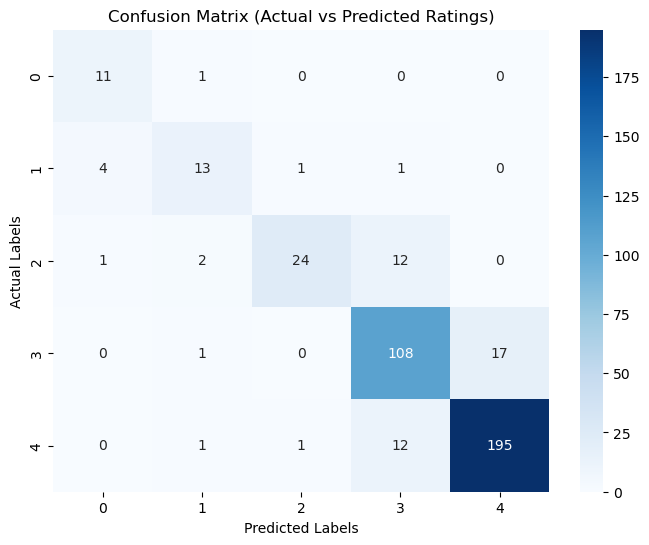

In [20]:
!pip install seaborn
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Calculate the confusion matrix
confusion_matrix = pd.crosstab(pd.Series(actual_labels, name='Actual'), pd.Series(predicted_labels, name='Predicted'))

# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.title('Confusion Matrix (Actual vs Predicted Ratings)')
plt.show()


In [21]:
# Create DataFrame with review text, actual label, and predicted label
df_results = pd.DataFrame({
    'Review Text': review_texts,
    'Actual Label': actual_labels,
    'Predicted Label': predicted_labels
})

# Display the DataFrame
print(df_results)


                                           Review Text  Actual Label  \
0    Being born in Glasgow, I loved all the old Sco...             3   
1    Great book love how Reed was able to pass his ...             4   
2    I first read Love Recipe in high school by bor...             4   
3    The Possesssion series is the dystopian series...             3   
4    Earleys' rendering of a Perfect Past has it's ...             2   
..                                                 ...           ...   
400  Carol O'Connell's novels operate on two levels...             3   
401  Three of Hearts is the first in Ms. Ferraro's ...             3   
402  Enjoyed following the story of Puma Son of Mou...             4   
403  I'm rounding up from a 3.5 star rating.I disco...             3   
404  I found "Cars" to be an incredibly fun book to...             4   

     Predicted Label  
0                  3  
1                  4  
2                  4  
3                  3  
4                  3

In [22]:
# Specify the path where you want to save the CSV file
file_path = "GPT2_Final.csv"

# Save the DataFrame to a CSV file
df_results.to_csv(file_path, index=False)  # Set index=False to exclude row indices in the CSV

print(f"DataFrame saved to {file_path}")


DataFrame saved to GPT2_Final.csv
